# Data Retrieval, Cleaning, and Exploratory Data Analysis

In [ ]:
# install and import libaries

!pip install pubchempy --quiet
!pip install tqdm --quiet
!pip install rdkit --quiet
!pip install --pre deepchem --quiet
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.12.1+cu113.html --quiet
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.12.1+cu113.html --quiet
!pip install torch-geometric
import deepchem as dc
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pubchempy as pcp
from multiprocessing import Pool, TimeoutError, Manager
from functools import partial
import time
import os
import pandas as pd
import pickle
import numpy as np 
import torch
from torch_geometric.data import Data
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt

# !python -c "import torch; print(torch.__version__)"
# !python -c "import torch; print(torch.version.cuda)"

In [ ]:
# connect to Drive

in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/DL_Course_Project") 
    in_colab = True
except:
    pass

!pwd

Mounted at /content/drive
/content/drive/My Drive/DL_Course_Project


In [ ]:
# variable whether or not to recreate the dataframes from scratch
# set to False because dataframe has been saved to a pickle

rerun = True
resave_data = True

### Bioassay Data downloaded from Pubchem Bioassay - CSV

https://pubchem.ncbi.nlm.nih.gov/bioassay/1285#section=Data-Table

In [ ]:
if rerun:
    assay_data = pd.read_csv("Data/AID_1285_datatable_all.csv") # csv downloaded directly from bioassay pubchem page

    # assay_data # top rows have descriptive information that need to be dropped

    assay_data = assay_data.iloc[4:].reset_index(drop=True) # dropping top rows
    assay_data['PUBCHEM_CID'] = assay_data['PUBCHEM_CID'].astype(int) 

    assay_data = assay_data.rename(columns={'PUBCHEM_CID': 'cid', 'PUBCHEM_ACTIVITY_OUTCOME': 'activity'}, errors='ignore')
    assay_data['cid'] = assay_data['cid'].astype(int)
    assay_data = assay_data[['cid', 'activity']]

    assay_data[assay_data["activity"] == 'Active']["Activity Label"] = 1

    assay_data["activity_label"] = (assay_data["activity"] == 'Active').astype(int)
    # assay_data.head(3)

### Compound Data for Bioassay Compounds - Downloaded from Pubchem - CSV

In [ ]:
if rerun:
    df = pd.read_csv("Data/Pubchem_Compounds.csv")
    # df.isosmiles.isna().sum() # every compound has isomeric smiles
    # df # looks like 4 compounds were not there (4 less rows than assay data)

In [ ]:
df.columns

df = df.drop(['cmpdsynonym', 'annothits', 'annothitcnt', 'aids', 
              'cidcdate', 'sidsrcname', 'depcatg','annotation'], axis=1, errors='ignore')

numeric_cols = ['mw', 'polararea', 'complexity',
       'xlogp', 'heavycnt', 'hbonddonor', 'hbondacc', 'rotbonds']
# df

#### Merge the Compound Data and Bioassay Information

In [ ]:
if rerun:   
    merged_df = df.merge(assay_data, how='left', on='cid')
    merged_df.head(3)

In [ ]:
if rerun:

    clean_df = merged_df.drop_duplicates(keep='first') # handful of duplicates
    clean_df = clean_df.reset_index(drop=True)

    # if resave_data: 
    #     clean_df.to_pickle('Data/full_dataset.pickle', compression='infer', storage_options=None)

    clean_df.head(3) # 'final' data for the analysis

### DataFrame saved to Pickle

In [ ]:
if not rerun:

    clean_df = pd.read_pickle("Data/full_dataset.pickle")
    clean_df.head()

## Exploratory Data Analysis

**XlogP**:   
is a program for the prediction of the octanol/water partition coefficients of organic compounds

**Complexity**:  
Estimate of how complicated the structure is, seen from the point of view of both the elements contained and the displayed structural features including symmetry.

In [ ]:
active = clean_df[clean_df['activity'] == 'Active']
inactive = clean_df[clean_df['activity'] == 'Inactive']
active.head()

,cid,cmpdname,mw,mf,polararea,complexity,xlogp,heavycnt,hbonddonor,hbondacc,rotbonds,inchi,isosmiles,inchikey,iupacname,meshheadings,activity,activity_label
4,2082,Albendazole,265.33,C12H15N3O2S,92.3,291.0,2.9,18,2,4,5,InChI=1S/C12H15N3O2S/c1-3-6-18-8-4-5-9-10(7-8)...,CCCSC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,HXHWSAZORRCQMX-UHFFFAOYSA-N,methyl N-(6-propylsulfanyl-1H-benzimidazol-2-y...,Albendazole,Active,1
9,3117,Disulfiram,296.50,C10H20N2S4,121.0,201.0,3.9,16,0,4,7,InChI=1S/C10H20N2S4/c1-5-11(6-2)9(13)15-16-10(...,CCN(CC)C(=S)SSC(=S)N(CC)CC,AUZONCFQVSMFAP-UHFFFAOYSA-N,"diethylcarbamothioylsulfanyl N,N-diethylcarbam...",Disulfiram,Active,1
11,3213,Ellipticine,246.31,C17H14N2,28.7,342.0,4.8,19,1,1,0,InChI=1S/C17H14N2/c1-10-14-9-18-8-7-12(14)11(2...,CC1=C2C=CN=CC2=C(C3=C1NC4=CC=CC=C43)C,CTSPAMFJBXKSOY-UHFFFAOYSA-N,"5,11-dimethyl-6H-pyrido[4,3-b]carbazole",NaN,Active,1
12,3334,Fenbendazole,299.30,C15H13N3O2S,92.3,363.0,3.6,21,2,4,4,InChI=1S/C15H13N3O2S/c1-20-15(19)18-14-16-12-8...,COC(=O)NC1=NC2=C(N1)C=C(C=C2)SC3=CC=CC=C3,HDDSHPAODJUKPD-UHFFFAOYSA-N,methyl N-(6-phenylsulfanyl-1H-benzimidazol-2-y...,Fenbendazole,Active,1
17,4622,Oxibendazole,249.27,C12H15N3O3,76.2,288.0,2.4,18,2,4,5,InChI=1S/C12H15N3O3/c1-3-6-18-8-4-5-9-10(7-8)1...,CCCOC1=CC2=C(C=C1)N=C(N2)NC(=O)OC,RAOCRURYZCVHMG-UHFFFAOYSA-N,methyl N-(6-propoxy-1H-benzimidazol-2-yl)carba...,NaN,Active,1


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


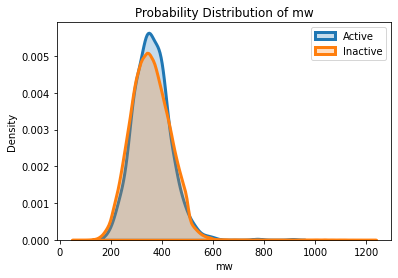

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


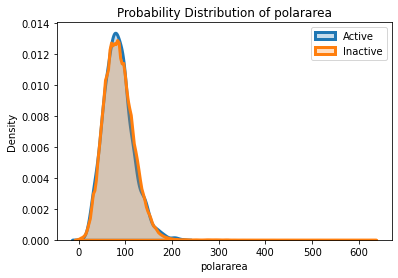

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


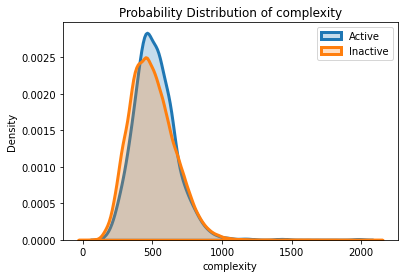

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


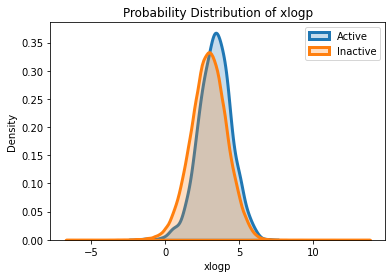

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


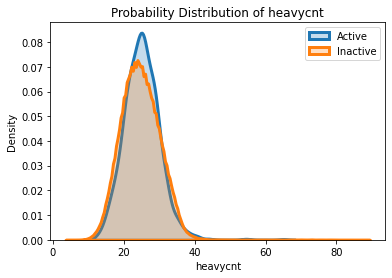

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


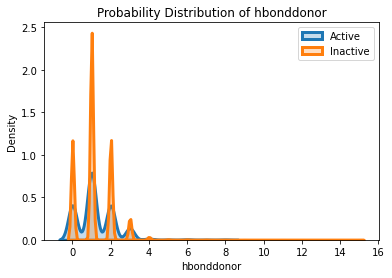

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


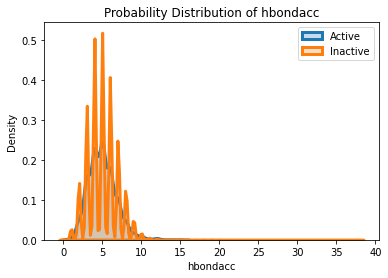

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


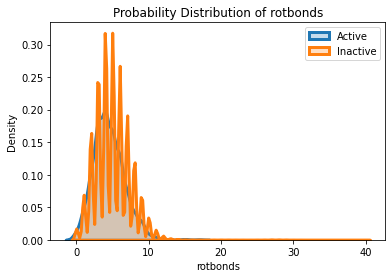

In [ ]:
for col in numeric_cols:

    sns.distplot(active[col], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = 'Active')

    sns.distplot(inactive[col], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3}, 
                    label = 'Inactive')
    
    plt.title(f"Probability Distribution of {col}")

    plt.legend()
    plt.show()